---
# Negative Stimulus

This notebook aims to elucidate which stimulus maximally elicits a negative response. Both the stimulus as the task as manipulated. The following runs were acquired:

- `run-1`: larger + attention task
- `run-2`: original + attention task
- `run-3`: annulus + attention task
- `run-4`: annulus + fixation task
- `run-5`: original + fixation task
- `run-6`: larger + fixation task

In [1]:
from linescanning import (
    utils,
    transform,
    plotting
)

import holeresponse as hr
import matplotlib.pyplot as plt
import numpy as np
import os
import nibabel as nb
opj = os.path.join

In [2]:
# set default paths
deriv = "/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives"
subject = "sub-001"
ft_path = opj(
    deriv, 
    "feat",
    "level1",
    subject,
    "ses-3")

In [3]:
# fetch zstat2 contrast (mean suppression)
n_runs = 6
zstat_files = [utils.get_file_from_substring(["zstat2.nii.gz"], opj(ft_path, f"run{i+1}.feat", "stats")) for i in range(n_runs)]
zstat_files

['/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level1/sub-001/ses-3/run1.feat/stats/zstat2.nii.gz',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level1/sub-001/ses-3/run2.feat/stats/zstat2.nii.gz',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level1/sub-001/ses-3/run3.feat/stats/zstat2.nii.gz',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level1/sub-001/ses-3/run4.feat/stats/zstat2.nii.gz',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level1/sub-001/ses-3/run5.feat/stats/zstat2.nii.gz',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level1/sub-001/ses-3/run6.feat/stats/zstat2.nii.gz']

In [4]:
# define reference slice
ref_slice = opj(os.path.dirname(deriv), subject, "ses-3", "anat", f"{subject}_ses-3_task-SRFa_acq-1slice_run-1_desc-anat.nii.gz")
if not os.path.exists(ref_slice):
    raise FileNotFoundError(f"Could not find slice-file '{ref_slice}'")

# set tfm to identity matrix
tfm = "identity"

# project stats into slice
tfm_zstat = []
tfm_niimg = []
for z in zstat_files:

    # define output file
    out_file = opj(os.path.dirname(z), os.path.basename(z).split(".")[0]+"_space-slice.nii.gz")
    
    # apply warp
    tfm_zstat.append(transform.ants_applytrafo(
        ref_slice,
        z,
        trafo=tfm,
        interp="lin",
        output=out_file)
    )

    tfm_niimg.append(nb.load(out_file))

In [5]:
# define beam
beam_file = opj(os.path.dirname(deriv), subject, "ses-3", "anat", f"{subject}_ses-3_task-SRFa_acq-1slice_run-1_desc-beam.nii.gz")
if not os.path.exists(ref_slice):
    raise FileNotFoundError(f"Could not find beam-file '{beam_file}'")

In [6]:
fig_dir = f"/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/{subject}"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir, exist_ok=True)

In [14]:
np.arange(1,7)

array([1, 2, 3, 4, 5, 6])

In [16]:

ddict = {
    "run": np.arange(1,(6+1)),
    "stim": np.array(["larger","original","annulus","annulus","original","larger"], dtype=object),
    "task": np.array(["attention","attention","attention","fixation","fixation","fixation"], dtype=object)
}

df_ = pd.DataFrame(ddict)
df_


,run,stim,task
0,1,larger,attention
1,2,original,attention
2,3,annulus,attention
3,4,annulus,fixation
4,5,original,fixation
5,6,larger,fixation


In [22]:
df_sort = df_.sort_values(["task","stim"])
df_sort

,run,stim,task
2,3,annulus,attention
0,1,larger,attention
1,2,original,attention
3,4,annulus,fixation
5,6,larger,fixation
4,5,original,fixation


Text(0.5, 1.05, "responses to 'suppression' contrast")

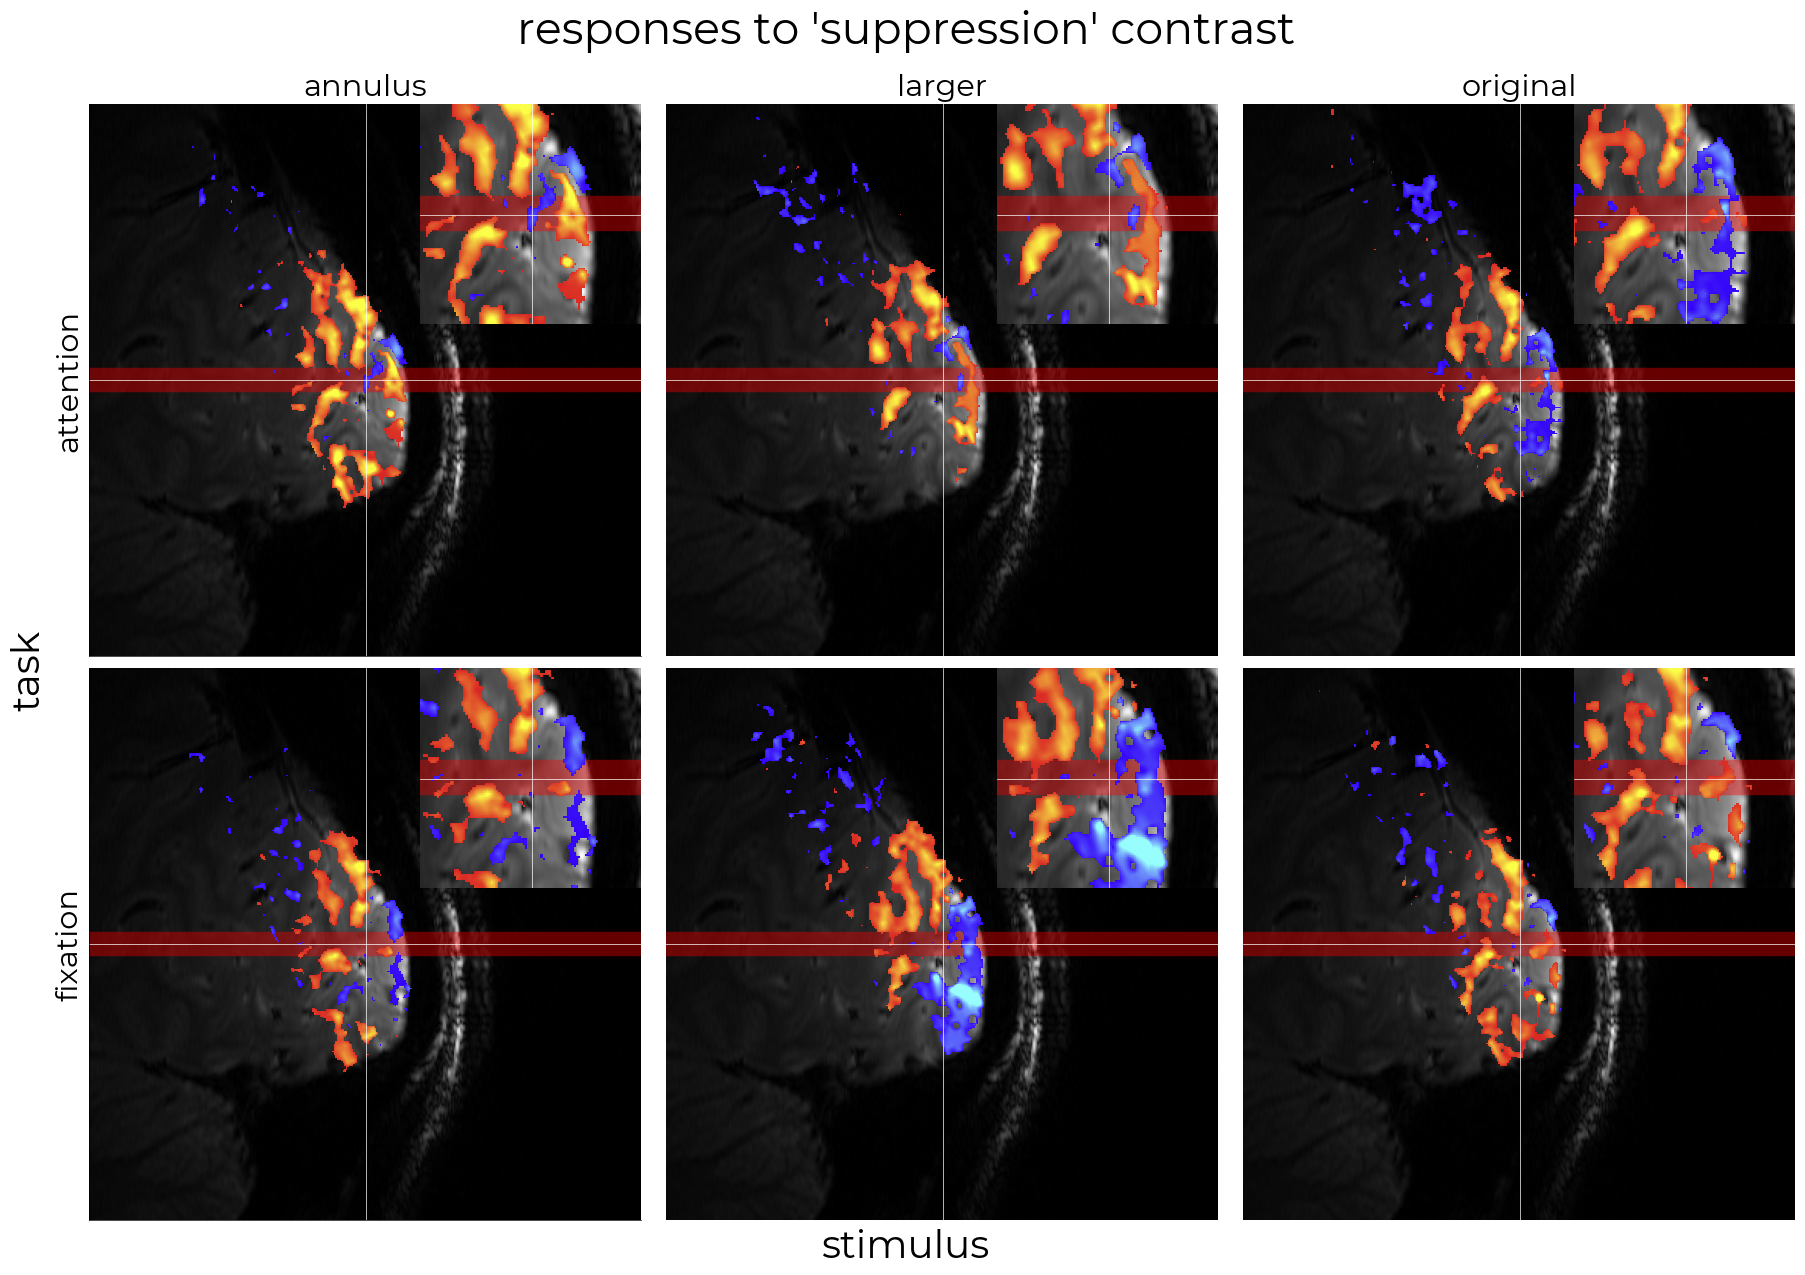

In [43]:

%matplotlib inline
fig,axs = plt.subplots(
    nrows=2,
    ncols=3, 
    figsize=(18,12), 
    constrained_layout=True)

for ix,ax in enumerate(axs.flatten()):
    
    info = df_sort.iloc[ix,:]
    obj_ = hr.data.CorrelationPlotter(
        slice_file=ref_slice,
        stats_file=tfm_zstat[(info.run-1)],
        beam_file=beam_file,
        t_thr=1.6
    )
    
    title = None
    if ix < 3:
        title = info.stim
    
    y_lbl = None
    if ix == 0 or ix == 3:
        y_lbl = info.task

    obj_.plot_images(
        axs=ax,
        title=title,
        extent=[180,540,180,540],
        inset_axis=[0.6,0.6,0.4,0.4],
        y_label=y_lbl,
        add_cross=True)

    obj_.img_axs.set_ylabel(y_lbl, fontsize=22)
fig.supylabel("task", fontsize=28)
fig.supxlabel("stimulus", fontsize=28)
fig.suptitle("responses to 'suppression' contrast", y=1.05, fontsize=32)

fname = opj(fig_dir, f"{subject}_ses-3_desc-suppression")
for ext in ["pdf"]:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
            facecolor="white"
    )    

In [33]:
obj_.slice_img.shape

(720, 720, 1)